# Predictive Churn Modeling

This notebook builds a simple and interpretable churn prediction model to complement the rule-based risk scoring system.


C:\Users\amosw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\amosw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\amosw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      1127
           1       0.00      0.00      0.00       373

    accuracy                           0.75      1500
   macro avg       0.38      0.50      0.43      1500
weighted avg       0.56      0.75      0.64      1500



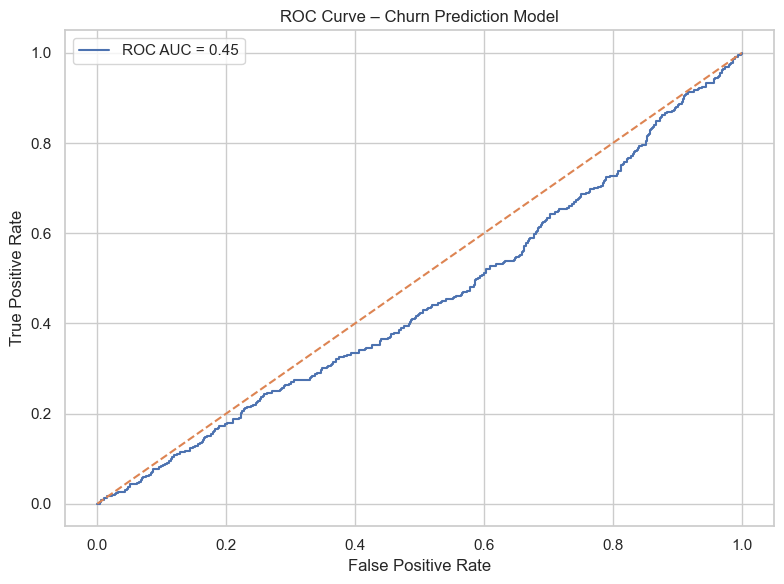

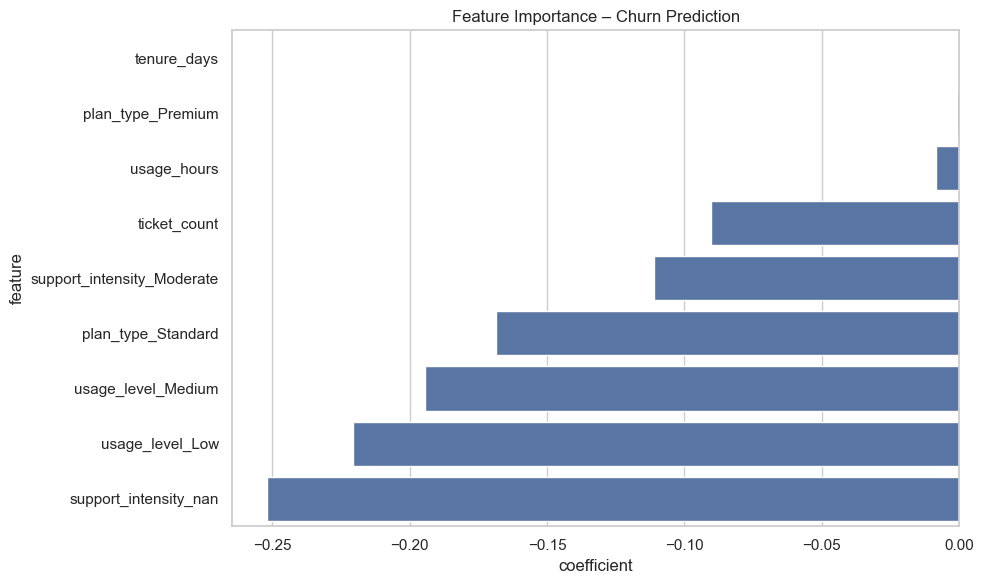

In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns

os.chdir("..")
sns.set(style="whitegrid")

# Load dataset
df = pd.read_csv("data/cleaned/customer_analysis_dataset.csv")
df.head()

# Define features and target
y = df["churned_flag"]
X = df[
    [
        "usage_hours",
        "ticket_count",
        "tenure_days",
        "plan_type",
        "support_intensity",
        "usage_level",
    ]
]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Preprocessing and model pipeline
numeric_features = ["usage_hours", "ticket_count", "tenure_days"]
categorical_features = ["plan_type", "support_intensity", "usage_level"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features),
    ]
)

model = LogisticRegression(max_iter=1000)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", model),
    ]
)

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred))

# ROC AUC metric
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Churn Prediction Model")
plt.legend()
plt.tight_layout()
plt.savefig("visuals/roc_curve_churn_model.png")
plt.show()

# Feature importance
feature_names = (
    numeric_features
    + list(
        pipeline.named_steps["preprocessor"]
        .named_transformers_["cat"]
        .get_feature_names_out(categorical_features)
    )
)

coefficients = pipeline.named_steps["model"].coef_[0]

importance = pd.DataFrame(
    {
        "feature": feature_names,
        "coefficient": coefficients,
    }
).sort_values(by="coefficient", ascending=False)

importance

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance, x="coefficient", y="feature")
plt.title("Feature Importance – Churn Prediction")
plt.tight_layout()
plt.savefig("visuals/feature_importance_churn_model.png")
plt.show()


## Model Insights

- Low product usage is the strongest predictor of churn.
- High support interaction significantly increases churn risk.
- Short customer tenure strongly correlates with churn probability.
- Basic plan customers show higher churn risk than premium tiers.
- The predictive model aligns closely with the rule-based risk score.
